# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

import warnings

from unidecode import unidecode
import string
from bs4 import BeautifulSoup
from html import unescape
import emoji
import gradio as gr
import os

from joblib import Parallel
from sklearn.utils.fixes import delayed
from multiprocessing import Pool

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

import pickle
import re

os.environ['NUMEXPR_MAX_THREADS'] = '32'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, PredefinedSplit, ParameterGrid

from xgboost import XGBClassifier, XGBRFClassifier

from datasets import load_dataset

from sentence_transformers import SentenceTransformer, util

warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Defining functions 

In [2]:
# function to remove urls
def remove_urls(input_str):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'',input_str)


# function to remove emojis
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)


# function for cleaning up text
def text_cleanup(input_str, anglo_chars=True):
  if input_str == None:
    return ""

  s = remove_urls(input_str) #remove URL
  s = re.sub('RT @[^\s]+','',s) #remove 'RT @user'
  s = re.sub('@[^\s]+','',s) #remove @user
  s = BeautifulSoup(unescape(s), 'lxml').text #remove HTML tags
  s = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", s) #separate alpha- num e.g. abc123 -> abc 123
  s = re.sub(r'#x20;|\s+|[\u200b]{1,}', ' ', str(s)).strip() #remove extra spaces
  s = re.sub(r'([,.!?":;$#%&/\-\'])+', r'\1', s) #remove repeated punctautions
  s = re.sub(r'[^A-Za-z0-9 ,.!?":;$#%&/\-\']+', '', s) if anglo_chars else s #remove non alphanum + punctuation chars
  s = remove_emoji(s).lower().strip().lstrip(string.punctuation).strip() #remove emojis

  return s


# function for vectorizing text in a data frame
def CleanupAndVectorize(df, vect_model, anglo_chars=True):

  df['text'] = df['text'].apply(text_cleanup, anglo_chars=anglo_chars)
  df = df.drop_duplicates(subset='text')

  labels = df.label.to_list()
  texts = df.text.apply(str).to_list()
  text_vects = vect_model.encode(texts, show_progress_bar=False, convert_to_numpy=True)

  return text_vects, np.array(labels)


# two functions for vectorizing and running the model (respectively) on manually entered text
def CleanupAndVectorizeText(text, vect_model, anglo_chars=True):
  text = text_cleanup(text, anglo_chars=anglo_chars)
  text_vect = vect_model.encode([text], show_progress_bar=False, convert_to_numpy=True)

  return text_vect

def prediction_fn(text, vect_model, sk_model):
  return sk_model.predict_proba(CleanupAndVectorizeText(text, vect_model, anglo_chars=False))[0,1].round(3)

# Reading the Data 

In [ ]:
df = pd.read_csv("hate_speech_english.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251093 entries, 0 to 251092
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   textid  251093 non-null  int64 
 1   text    251093 non-null  object
 2   label   251093 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.7+ MB


In [ ]:
df.head()

,textid,text,label
0,1100000,1 . knew he was gettin pussy later 2 . he yakked 3 . you look stoned as hell,1
1,1100001,your girl's hoe friends gonna gas her to cheat on you. a tall nigga with abs start stroking on her in the club & they,1
2,1100003,stick to hockey faggot. you're finished,1
3,1100004,all y'all dudes that just favorite this is a faggot smh,1
4,1100005,you hang out with a hoe you gonna turn into a hoe,1


# EDA

In [ ]:
df.isnull().sum()

textid    0
text      0
label     0
dtype: int64

We see that there are no null values in the data

Text(0.5, 0, 'label')

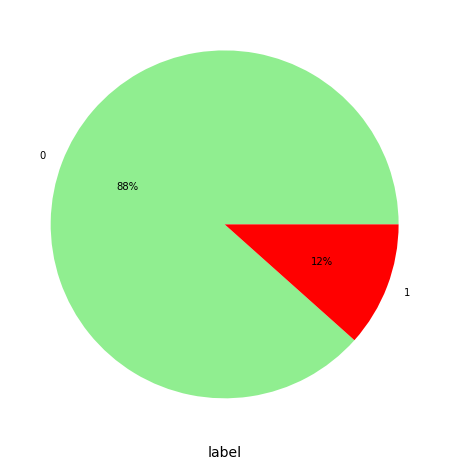

In [ ]:
# Label distribution
df['label'].value_counts(normalize= True).plot(kind = 'pie', figsize = (8,8), autopct='%1.f%%', ylabel = "", colors=['lightgreen','red']).set_xlabel('label', fontsize=14)

We see that in the above 88% of the data is hate and 12% of the 
data is non-hate.

In [ ]:
# total number of words and characters in each text
df['num_words'] = df['text'].str.split().str.len()
df['num_char'] = df['text'].str.len()

In [ ]:
df.head()

,textid,text,label,num_words,num_char
0,1100000,1 . knew he was gettin pussy later 2 . he yakked 3 . you look stoned as hell,1,19,76
1,1100001,your girl's hoe friends gonna gas her to cheat on you. a tall nigga with abs start stroking on her in the club & they,1,25,117
2,1100003,stick to hockey faggot. you're finished,1,6,39
3,1100004,all y'all dudes that just favorite this is a faggot smh,1,11,55
4,1100005,you hang out with a hoe you gonna turn into a hoe,1,12,49


Text(0.5, 0, 'Number of words')

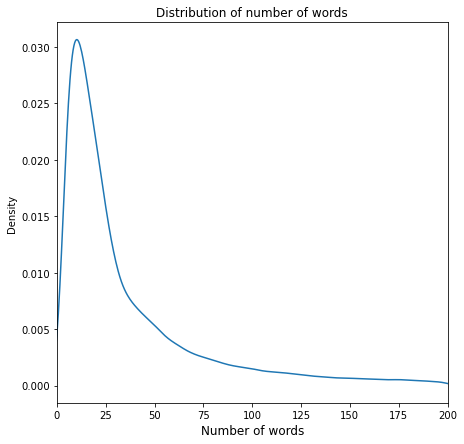

In [ ]:
df['num_words'].plot(kind= 'kde',figsize=(7,7), xlim=(0, 200),title="Distribution of number of words").set_xlabel('Number of words', fontsize=12)

We see that the majority of the texts have less than 25 words

Text(0.5, 0, 'Number of characters')

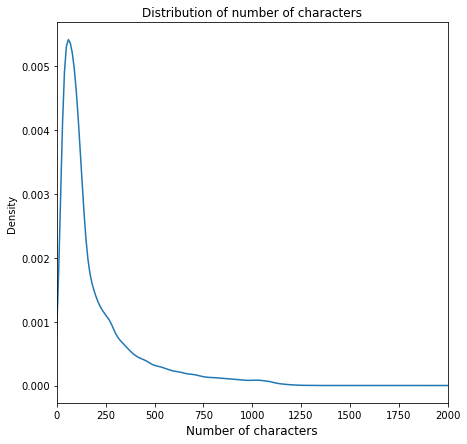

In [ ]:
df['num_char'].plot(kind= 'kde',figsize=(7,7), xlim=(0, 2000),title="Distribution of number of characters").set_xlabel('Number of characters', fontsize=12)

We see that the majority of the texts have less than 250 characters

# Hate proportion

In [ ]:
female = ['woman', 'women', r'\b(she)\b', r'\b(her)\b', 'herself', 'girl', 'wife', 'mother', 'sister', 'daughter']
male = [r'\b(man)\b', r'\b(men)\b', r'\b(he)\b', r'\b(him)\b', r'\b(his)\b', 'himself', 'boy', 'husband', 'father', 'brother', r'\b(son)\b']

lgbtq = [r'g+a+y+', 'lesbian', r'q+u+e+r+', 'bisexual', 'trans-sexual', 'trans sexual', 'trans people'] #, r'f+a+g+'
straight = ['straight', 'heterosexual']

jew = ['jew', 'yid']
muslim = ['muslim', 'islam']
hindu = ['hindu']
christian = ['christian']

black = ['blacks', 'black people'] #, r'n+i+g+a+h+', r'n+i+g+e+r+', r'n+i+g+a+'
asian = ['brown people', 'asians', 'yellow people']
latino = ['latinos', 'latinas', 'hispanic']
white = ['whites', 'white people', 'caucasian']

In [ ]:
df['female'] = df.text.str.contains('|'.join(female))*1
df['male'] = df.text.str.contains('|'.join(male))*1

df['straight'] = df.text.str.contains('|'.join(straight))*1
df['lgbtq'] = df.text.str.contains('|'.join(lgbtq))*1

df['christian'] = df.text.str.contains('|'.join(christian))*1
df['jew'] = df.text.str.contains('|'.join(jew))*1
df['muslim'] = df.text.str.contains('|'.join(muslim))*1
df['hindu'] = df.text.str.contains('|'.join(hindu))*1

df['white'] = df.text.str.contains('|'.join(white))*1
df['black'] = df.text.str.contains('|'.join(black))*1
df['asian'] = df.text.str.contains('|'.join(asian))*1
df['latino'] = df.text.str.contains('|'.join(latino))*1

a = df.drop(['textid','num_words','num_char'],axis=1).groupby('label').mean().T
a["hate_proportion"] = a[1]/a[0]
a.T

,female,male,straight,lgbtq,christian,jew,muslim,hindu,white,black,asian,latino
label,,,,,,,,,,,,
0,0.060759,0.132930,0.003221,0.00887,0.005203,0.008307,0.009226,0.001716,0.006199,0.003469,0.000770,0.000788
1,0.145609,0.110615,0.006285,0.07411,0.007899,0.042343,0.045434,0.002370,0.024520,0.026821,0.006868,0.002301
hate_proportion,2.396493,0.832130,1.951060,8.35471,1.517999,5.097155,4.924425,1.380542,3.955537,7.731895,8.915784,2.918518


We see that: 

* The ratio of hate proportion for female to male is 2.39:0.83, which clearly shows that there is more hate towards females compared to males in the data

* The ratio of hate proportion for lgbtq to straight is 8.35:1.95, which clearly shows that there is more hate towards lgbtq compared to males in the data

* The ratio of hate proportion for jews (5.09) and muslims (4.9) is significantly more compared to christians (1.51) and hindus (1.38) in the data

* The ratio of hate proportion for blacks (7.73), asians (8.9)  is significantly more compared to whites (3.9) and latinos (2.9) in the data

# Building counterfactuals

In [ ]:
# counterfactuals

orientation_subs1 = {r'g+a+y+':'heterosexual', 'lesbian':'heterosexual', 'lesbo':'heterosexual', r'q+u+e+r+':'heterosexual', 'bisexual':'heterosexual', 'trans-sexual':'heterosexual'}
orientation_subs2 = {r'g+a+y+':'straight', 'lesbian':'straight', 'lesbo':'straight', r'q+u+e+r+':'straight', 'bisexual':'straight', 'trans people':'straight people'}

gender_subs1 = {'woman':'man', 'women':'men', r'\b(she)\b':'he', r'\b(her)\b':'him', 'herself':'himself', 'girl':'boy', 'wife':'husband', 'mother':'father', 'sister':'brother', 'daughter':'son'}
gender_subs2 = {r'\b(man)\b': 'woman', r'\b(men)\b': 'women', r'\b(he)\b': 'she', r'\b(his)\b': 'her', r'\b(him)\b': 'her', 'himself': 'herself', 'boy': 'girl', 'husband': 'wife', 'father': 'mother', 'brother': 'sister', r'\b(son)\b': 'daughter'}

religion_subs1 = {'muslim':'christian', 'jewish':'christian', 'jew':'christian', 'hindu':'christian', 'islamic':'christian', 'islam':'christianity', 'yids':'christians'}
religion_subs2 = {'muslim':'hindu', 'jewish':'hindu', 'jew':'hindu', 'christianity':'hinduism', 'christian':'hindu', r'yids':'hindus'}
religion_subs3 = {'jewish':'muslim', 'hindu':'muslim', 'christianity':'islam', 'christian':'muslim', 'yids':'muslims'}
religion_subs4 = {'muslim':'jew', 'hindu':'jew', 'christianity':'judiasm', 'christian':'jew', 'islam':'judiasm'}

race_subs1 = {'blacks':'caucasians', 'black people':'white people', 'asian':'white', 'oriental':'white', 'arab':'white', 'latino':'white', 'hispanic':'white', 'refugee':'white', 'foreigner':'white', 'immigrant':'white', 'migrant':'white', 'africa':'america', 'asia':'america'}
race_subs2 = {'blacks':'asians', 'black people':'yellow people', 'arab':'asian', 'refugee':'asian', 'foreigner':'asian', 'immigrant':'asian', 'migrant':'asian', 'africa':'asia'}
race_subs3 = {'blacks':'hispanics', 'asian':'hispanic', 'oriental':'hispanic', 'arab':'hispanic', 'refugee':'hispanic', 'foreigner':'hispanic', 'immigrant':'hispanic', 'migrant':'hispanic', 'africa':'south america', 'asia':'south america'}
race_subs4 = {'blacks':'native americans', 'black people':'indigenous people'}
race_subs5 = {'black people':'brown people'}
race_subs6 = {'asian':'black', 'arab':'black', 'refugee':'black', 'foreigner':'black', 'immigrant':'black', 'migrant':'black'}
race_subs7 = {'white':'black'}
race_subs8 = {'white':'brown'}

subs = [gender_subs1, gender_subs2, orientation_subs1, orientation_subs2,
        religion_subs1, religion_subs2, religion_subs3, religion_subs4,
        race_subs1, race_subs2, race_subs3, race_subs4, race_subs5, race_subs6, race_subs7, race_subs8]

In [ ]:
%%time

df = pd.read_csv("hate_speech_english.csv")

df['variant'] = 0

dfs = [df]

for i,sub in enumerate(subs):
  df1 = df.copy()
  df1['text'] = df1['text'].replace(sub, regex=True)
  df1['variant'] = i+1
  dfs.append(df1)

df_all = pd.concat(dfs).sort_values('variant').drop_duplicates('text').sort_values('textid')

df_all['text'] = df_all['text'].parallel_apply(text_cleanup)

df_all.to_csv('hate_speech_eng_cf.csv', index=False)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382654 entries, 0 to 251092
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   textid   382654 non-null  int64 
 1   text     382654 non-null  object
 2   label    382654 non-null  int64 
 3   variant  382654 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 14.6+ MB
CPU times: user 1min 20s, sys: 1.77 s, total: 1min 22s
Wall time: 4min 1s


In [ ]:
df_all.head()

,textid,text,label,variant
0,1100000,1 . knew he was gettin pussy later 2 . he yakked 3 . you look stoned as hell,1,0
0,1100000,1 . knew she was gettin pussy later 2 . she yakked 3 . you look stoned as hell,1,2
1,1100001,your boy's hoe friends gonna gas him to cheat on you. a tall nigga with abs start stroking on him in the club & they,1,1
1,1100001,your girl's hoe friends gonna gas her to cheat on you. a tall nigga with abs start stroking on her in the club & they,1,0
2,1100003,stick to hockey faggot. you're finished,1,0


In [ ]:
df = df_all.copy()

df['female'] = df.text.str.contains('|'.join(female))*1
df['male'] = df.text.str.contains('|'.join(male))*1

df['straight'] = df.text.str.contains('|'.join(straight))*1
df['lgbtq'] = df.text.str.contains('|'.join(lgbtq))*1

df['christian'] = df.text.str.contains('|'.join(christian))*1
df['jew'] = df.text.str.contains('|'.join(jew))*1
df['muslim'] = df.text.str.contains('|'.join(muslim))*1
df['hindu'] = df.text.str.contains('|'.join(hindu))*1

df['white'] = df.text.str.contains('|'.join(white))*1
df['black'] = df.text.str.contains('|'.join(black))*1
df['asian'] = df.text.str.contains('|'.join(asian))*1
df['latino'] = df.text.str.contains('|'.join(latino))*1

a = df.drop(['textid','variant'],axis=1).groupby('label').mean().T
a["hate_proportion"] = a[1]/a[0]
a.T

,female,male,straight,lgbtq,christian,jew,muslim,hindu,white,black,asian,latino
label,,,,,,,,,,,,
0,0.148887,0.162541,0.015967,0.009912,0.019173,0.019441,0.019888,0.014183,0.016058,0.014403,0.013824,0.015281
1,0.152014,0.159074,0.073194,0.052490,0.046571,0.063358,0.049870,0.038678,0.067521,0.061262,0.058826,0.046879
hate_proportion,1.021004,0.978674,4.584125,5.295449,2.428934,3.259043,2.507572,2.727152,4.204794,4.253468,4.255429,3.067849


# Sentence Embeddings

In [4]:
vect_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') #multi-lingual language model

# Splitting the data into train and test sets

In [ ]:
# Splitting the dataset (df) into train and validation sets
df = pd.read_csv('hate_speech_eng_cf.csv')
df_train, df_test = train_test_split(df, train_size=0.8, random_state=9713)

# Text Vectorization

In [ ]:
%%time

X_train, y_train = CleanupAndVectorize(df_train, vect_model)
pickle.dump(X_train, open('X_train_hs_xlm.pkl', 'wb'), protocol=4)
pickle.dump(y_train, open('y_train_hs_xlm.pkl', 'wb'))

X_test, y_test = CleanupAndVectorize(df_test, vect_model)
pickle.dump(X_test, open('X_test_hs_xlm.pkl', 'wb'), protocol=4)
pickle.dump(y_test, open('y_test_hs_xlm.pkl', 'wb'))

CPU times: user 2d 21h 47min 48s, sys: 6h 46min 31s, total: 3d 4h 34min 20s
Wall time: 9h 53min 18s


In [5]:
%%time
X_train = pickle.load(open('X_train_hs_xlm.pkl', 'rb'))
y_train = pickle.load(open('y_train_hs_xlm.pkl', 'rb'))

X_test = pickle.load(open('X_test_hs_xlm.pkl', 'rb'))
y_test = pickle.load(open('y_test_hs_xlm.pkl', 'rb'))

y_train.mean(), y_test.mean()

CPU times: user 313 ms, sys: 1.18 s, total: 1.49 s
Wall time: 1.49 s


(0.16910849560470792, 0.17118553265996786)

# Model Building

# Logistic Regression

In [ ]:
%%time
# GridSearchCV for Logistic Regression

hyper_params_cv_lr = {'class_weight': ['balanced', None],
                      'penalty': ['l1', 'l2', 'elasticnet'],
                      'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


model = GridSearchCV(estimator=LogisticRegression(), 
                     param_grid=hyper_params_cv_lr,
                     verbose=1,
                     cv=3, 
                     scoring = "f1",
                     n_jobs = -1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
{'C': 100, 'class_weight': None, 'penalty': 'l2'}
CPU times: user 1min 25s, sys: 2.18 s, total: 1min 27s
Wall time: 1min 52s


In [ ]:
%%time
model  = LogisticRegression(C=100, class_weight=None, penalty='l2', random_state=9713)
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)[:,1].round(3)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    254355
           1       0.81      0.74      0.78     51768

    accuracy                           0.93    306123
   macro avg       0.88      0.86      0.87    306123
weighted avg       0.93      0.93      0.93    306123
 

[[245591   8764]
 [ 13211  38557]]
CPU times: user 1min 28s, sys: 1.74 s, total: 1min 30s
Wall time: 7.19 s


In [ ]:
y_pred_test = model.predict_proba(X_test)[:,1].round(3)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     63430
           1       0.81      0.73      0.77     13101

    accuracy                           0.93     76531
   macro avg       0.88      0.85      0.86     76531
weighted avg       0.92      0.93      0.92     76531
 

[[61180  2250]
 [ 3486  9615]]


# Random Forest Classifier

In [ ]:
%%time
# GridSearchCV for Random Forest Classifier

hyper_params_cv_rf = {'max_features': [0.05, 0.10, 0.25],
                      'min_samples_leaf': [5, 13, 21, 35]}


model = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                     param_grid=hyper_params_cv_rf,
                     verbose=1,
                     cv=3,
                     scoring = "f1",
                     n_jobs=-1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'max_features': 0.25, 'min_samples_leaf': 5}
CPU times: user 6h 11min 22s, sys: 1.4 s, total: 6h 11min 24s
Wall time: 1h 57min 38s


In [ ]:
%%time
model = RandomForestClassifier(max_features=0.25, min_samples_leaf=5, n_jobs=-1, random_state=9713) # max_features=0.05, min_samples_leaf=49, n_estimators=199
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)[:,1].round(3)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    254355
           1       1.00      0.96      0.98     51768

    accuracy                           0.99    306123
   macro avg       0.99      0.98      0.99    306123
weighted avg       0.99      0.99      0.99    306123
 

[[254193    162]
 [  2207  49561]]
CPU times: user 8h 40s, sys: 0 ns, total: 8h 40s
Wall time: 41min 42s


In [ ]:
y_pred_test = model.predict_proba(X_test)[:,1].round(3)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     63430
           1       0.89      0.65      0.75     13101

    accuracy                           0.93     76531
   macro avg       0.91      0.82      0.85     76531
weighted avg       0.92      0.93      0.92     76531
 

[[62368  1062]
 [ 4618  8483]]


# Gradient Boosting

In [ ]:
%%time

# GridSearchCV for XGboost Classifier

hyper_params_cv_xgb = {'max_depth': [5, 25, 50, 100],
                      'n_estimators': [250, 500, 1000]}


model = GridSearchCV(estimator=XGBClassifier(verbosity=0, silent=True, use_label_encoder=False), 
                     param_grid=hyper_params_cv_xgb,
                     verbose=1,
                     cv=3, 
                     scoring = "f1",
                     n_jobs = -1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'max_depth': 5, 'n_estimators': 1000}
CPU times: user 11h 45min 21s, sys: 37.7 s, total: 11h 45min 59s
Wall time: 6h 54min 28s


In [ ]:
%%time
model  = XGBClassifier(max_depth=5, n_estimators=1000, n_jobs=-1, random_state=9713)
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)[:,1].round(3)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

[16:11:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254355
           1       1.00      1.00      1.00     51768

    accuracy                           1.00    306123
   macro avg       1.00      1.00      1.00    306123
weighted avg       1.00      1.00      1.00    306123
 

[[254344     11]
 [    12  51756]]
CPU times: user 21h 1min 9s, sys: 0 ns, total: 21h 1min 9s
Wall time: 1h 37min 53s


In [ ]:
y_pred_test = model.predict_proba(X_test)[:,1].round(3)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     63430
           1       0.90      0.85      0.87     13101

    accuracy                           0.96     76531
   macro avg       0.93      0.91      0.92     76531
weighted avg       0.96      0.96      0.96     76531
 

[[62155  1275]
 [ 2022 11079]]


# KNN

In [ ]:
%%time
# GridSearchCV for KNN

hyper_params_cv_knn = {'n_neighbors': [3, 7, 15, 25],
                       'weights': ['uniform','distance']}


model = GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=hyper_params_cv_knn,
                     verbose=1,
                     cv=3, 
                     scoring = "f1",
                     n_jobs = -1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'n_neighbors': 7, 'weights': 'distance'}
CPU times: user 598 ms, sys: 1.56 s, total: 2.16 s
Wall time: 35min 19s


In [ ]:
%%time
model = KNeighborsClassifier(n_neighbors=7, weights='distance')
model.fit(X_train, y_train)


y_pred_train = model.predict_proba(X_train)[:,1].round(3)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254355
           1       1.00      1.00      1.00     51768

    accuracy                           1.00    306123
   macro avg       1.00      1.00      1.00    306123
weighted avg       1.00      1.00      1.00    306123
 

[[254347      8]
 [     0  51768]]
CPU times: user 5h 39min 13s, sys: 14min 39s, total: 5h 53min 52s
Wall time: 1h 21min 25s


In [ ]:
y_pred_test = model.predict_proba(X_test)[:,1].round(3)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     63430
           1       0.84      0.89      0.87     13101

    accuracy                           0.95     76531
   macro avg       0.91      0.93      0.92     76531
weighted avg       0.95      0.95      0.95     76531
 

[[61161  2269]
 [ 1377 11724]]


# SVM

In [ ]:
%%time
# GridSearchCV for SVM

hyper_params_cv_svm = {'C': [0.001, 0.01, 0.1, 1, 10],
                       'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                       'class_weight': ['balanced', None]}


model = GridSearchCV(estimator=SVC(), 
                     param_grid=hyper_params_cv_svm,
                     verbose=1,
                     cv=3, 
                     scoring = "f1",
                     n_jobs = -1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'C': 10, 'class_weight': None, 'kernel': 'rbf'}
CPU times: user 2h 11min 21s, sys: 2.86 s, total: 2h 11min 24s
Wall time: 1d 2h 21min 52s


In [ ]:
%%time
model = SVC(C = 10, class_weight = None, kernel = 'rbf')
model.fit(X_train, y_train)

CPU times: user 13h 25min 14s, sys: 1.68 s, total: 13h 25min 15s
Wall time: 13h 25min 18s


SVC(C=10)

In [ ]:
%%time
y_pred_train = model.predict(X_train)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254355
           1       1.00      1.00      1.00     51768

    accuracy                           1.00    306123
   macro avg       1.00      1.00      1.00    306123
weighted avg       1.00      1.00      1.00    306123
 

[[254116    239]
 [   174  51594]]
CPU times: user 3h 32min 26s, sys: 624 ms, total: 3h 32min 26s
Wall time: 3h 32min 27s


In [ ]:
%%time
y_pred_test = model.predict(X_test)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     63430
           1       0.95      0.95      0.95     13101

    accuracy                           0.98     76531
   macro avg       0.97      0.97      0.97     76531
weighted avg       0.98      0.98      0.98     76531
 

[[62830   600]
 [  705 12396]]
CPU times: user 52min 41s, sys: 160 ms, total: 52min 42s
Wall time: 52min 42s


# Neural Network (MLP Classifier)

In [ ]:
%%time
# GridSearchCV for MLP

hyper_params_cv_mlp = {'hidden_layer_sizes' : [(512,128,32,8), (256,84,28,9), (192,48,12)],
                       'alpha': [0.0001, 0.001, 0.01, 0.1],
                       'activation': ['tanh', 'relu']}


model = GridSearchCV(estimator=MLPClassifier(batch_size=512, max_iter=10), 
                     param_grid=hyper_params_cv_mlp,
                     verbose=1,
                     cv=3, 
                     scoring = "f1",
                     n_jobs = -1,
                     return_train_score=True)

model.fit(X_train, y_train)

print(model.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/anaconda3/l

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (512, 128, 32, 8)}
CPU times: user 11min 29s, sys: 19.8 s, total: 11min 49s
Wall time: 36min 54s


In [10]:
%%time

from sklearn.exceptions import ConvergenceWarning #
warnings.simplefilter("ignore", category=ConvergenceWarning) #

model = MLPClassifier(hidden_layer_sizes=(512, 128, 32, 8), max_iter=10, alpha=0.001, verbose=True, batch_size=512, random_state=9713)
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)[:,1].round(3)
print(classification_report(y_train, (y_pred_train>=0.5)*1), '\n')
print(confusion_matrix(y_train, (y_pred_train>=0.5)*1))

Iteration 1, loss = 0.18141726
Iteration 2, loss = 0.12757201
Iteration 3, loss = 0.10237073
Iteration 4, loss = 0.08189240
Iteration 5, loss = 0.06599390
Iteration 6, loss = 0.05452049
Iteration 7, loss = 0.04615975
Iteration 8, loss = 0.03898890
Iteration 9, loss = 0.03424996
Iteration 10, loss = 0.03128178
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254355
           1       0.98      0.98      0.98     51768

    accuracy                           0.99    306123
   macro avg       0.99      0.99      0.99    306123
weighted avg       0.99      0.99      0.99    306123
 

[[253124   1231]
 [   838  50930]]
CPU times: user 11min 47s, sys: 18.2 s, total: 12min 5s
Wall time: 45.9 s


In [7]:
y_pred_test = model.predict_proba(X_test)[:,1].round(3)
print(classification_report(y_test, (y_pred_test>=0.5)*1), '\n')
print(confusion_matrix(y_test, (y_pred_test>=0.5)*1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     63430
           1       0.92      0.93      0.92     13101

    accuracy                           0.97     76531
   macro avg       0.95      0.95      0.95     76531
weighted avg       0.97      0.97      0.97     76531
 

[[62357  1073]
 [  963 12138]]


# Testing on multilingual data

In [ ]:
df1 = pd.read_csv('hs_multilingual_labeled.csv')
df1['lang'].value_counts().sort_index()

ar    105
da     99
en    102
es     96
gr    113
hi    102
pt    100
tr    102
zh    100
Name: lang, dtype: int64

In [ ]:
%%time
df_ar = df1[df1['lang']=='ar'][['text','label']] # arabic dataset
df_da = df1[df1['lang']=='da'][['text','label']] # danish dataset
df_en = df1[df1['lang']=='en'][['text','label']] # english dataset
df_gr = df1[df1['lang']=='gr'][['text','label']] # greek dataset
df_hi = df1[df1['lang']=='hi'][['text','label']] # hindi dataset
df_pt = df1[df1['lang']=='pt'][['text','label']] # portuguese dataset
df_tr = df1[df1['lang']=='tr'][['text','label']] # turkish dataset
df_zh = df1[df1['lang']=='zh'][['text','label']] # chinese dataset


X_ar, y_ar= CleanupAndVectorize(df_ar, vect_model, anglo_chars=False)
X_da, y_da= CleanupAndVectorize(df_da, vect_model, anglo_chars=False)
X_en, y_en= CleanupAndVectorize(df_en, vect_model, anglo_chars=True)
X_gr, y_gr= CleanupAndVectorize(df_gr, vect_model, anglo_chars=False)
X_hi, y_hi= CleanupAndVectorize(df_hi, vect_model, anglo_chars=False)
X_pt, y_pt= CleanupAndVectorize(df_pt, vect_model, anglo_chars=False)
X_tr, y_tr= CleanupAndVectorize(df_tr, vect_model, anglo_chars=False)
X_zh, y_zh= CleanupAndVectorize(df_zh, vect_model, anglo_chars=False)

CPU times: user 35min 4s, sys: 2min 59s, total: 38min 4s
Wall time: 2min 54s


# Arabic dataset

In [ ]:
df_ar.sample(5)

,text,label
45,قرّبنا يا محجوبقرّبنا يا عظمة url,0
65,الكردي ما هذه العنصرية البغيضة يا مزورين يا كارهي دين الله يا عبيد اتاتورك,1
20,يا هناي و ياعزوتي يا مصدر فرحتي يا اغلى رجل حطني القدر بنته url,0
98,ترى ماهو بشطارتك فزت يا فار يا مرتشي يا حرامي البطولات,1
96,و ايه فرقة السحالي دي هو يا محشي يا سحالي يارب مفيش وسط,1


In [ ]:
y_pred_ar = model.predict_proba(X_ar)[:,1].round(3)
print(classification_report(y_ar, (y_pred_ar>=0.5)*1), '\n')
print(confusion_matrix(y_ar, (y_pred_ar>=0.5)*1))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.96      0.96      0.96        52

    accuracy                           0.96       105
   macro avg       0.96      0.96      0.96       105
weighted avg       0.96      0.96      0.96       105
 

[[51  2]
 [ 2 50]]


# Danish dataset

In [ ]:
df_da.sample(5)

,text,label
135,uden tvivl den mest kendte skuespiller i verdenshistorien,0
199,hvilket barbarisk middelalderligt og primitivt land mon han kommer nå jo,1
170,ah og vi har allerede fået bygget en mur mod indvandring fra vest kan jeg se kun et spørgsmål om tid før den bliver forlænget for at stoppe svensken,1
189,ind og ruske tremmer med hendeden syge kælling,1
137,tænk lige på hvad du kan gøre næste gang skal koge pasta,0


In [ ]:
y_pred_da = model.predict_proba(X_da)[:,1].round(3)
print(classification_report(y_da, (y_pred_da>=0.5)*1), '\n')
print(confusion_matrix(y_da, (y_pred_da>=0.5)*1))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92        49
           1       0.98      0.86      0.91        50

    accuracy                           0.92        99
   macro avg       0.93      0.92      0.92        99
weighted avg       0.93      0.92      0.92        99
 

[[48  1]
 [ 7 43]]


# English dataset

In [ ]:
df_en.sample(5)

,text,label
912,love fat hoes n tight clothes n granny panties seeeexxaaaay.,1
854,dan rather supplied her with unimpeachable documentation and she is just waiting for snopes to verify it for her.,0
842,just because they are in super max does not mean they will never be out among us again .,0
904,this doesnt apply to you but i hate you and your leo cunt twat whore kin.,1
918,i'll show you how much of a fag i am,1


In [ ]:
y_pred_en = model.predict_proba(X_en)[:,1].round(3)
print(classification_report(y_en, (y_pred_en>=0.5)*1), '\n')
print(confusion_matrix(y_en, (y_pred_en>=0.5)*1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.98      0.99        51

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102
 

[[51  0]
 [ 1 50]]


# Greek dataset

In [ ]:
df_gr.sample(5)

,text,label
411,οχι είσαι αδωνική νδ βαθιά μαύρη δεξιά αλλά είσαι και κότα,1
328,χμμ νικόλα θα είμαστε όλοι εκεί με μπανάνες να είσαι σίγουρος,0
362,άκου εδώ μαλάκα η αλβανία στοχοποιεί κ κυνηγάει τους έλληνες της βηπείρου αρνείται να πάρει 'πρόσφυγες' υποβλέπει εδάφη γειτόνων της τις μαλακίες σου να τις πείς στα πατριωτάκια σου όχι εδώ,1
395,kalytera οι καρκίνοι γυναίκες είστε τα καλύτερατα πιο γλυκά κι ευαίσθητασπασαρχίδικα κορίτσια γαμώ τη γκρίνια σας μέσα,1
346,τι λεω ο τρελος πριν από πολλά πολλά χρόνια όταν ήμουν ετών παντρεύτηκα μία γυναίκα χήρα αυτή η χήρα είχε μία μεγάλη κόρη ο πατέρας μου ερωτεύτηκε την κόρη της χήρας και σύντομα παντρεύτηκαν το γεγονός,0


In [ ]:
y_pred_gr = model.predict_proba(X_gr)[:,1].round(3)
print(classification_report(y_gr, (y_pred_gr>=0.5)*1), '\n')
print(confusion_matrix(y_gr, (y_pred_gr>=0.5)*1))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        52
           1       0.91      0.95      0.93        61

    accuracy                           0.92       113
   macro avg       0.92      0.92      0.92       113
weighted avg       0.92      0.92      0.92       113
 

[[46  6]
 [ 3 58]]


# Hindi dataset

In [ ]:
df_hi.sample(5)

,text,label
492,ये २१वी सदी का ग़दर देख लो जाहिलों की तरह यें गुंडे बेचारे अकेले मार्शल पे हमला करके मर्द बन रहे हैं इनका कच्छा खोलो तो साले सारे के सारे नपुंसक हैं पता चल जाएगा महिलाएँ भी कितनी डरी हुई हैं इन हिजड़ों से,1
511,मुझे तो लगता है ये कमीनी हालाला के मज़े लेना चाहती हैं इसलिए धर्म परिवर्तन करवायी हैं,1
483,बोहोत ही फूहड़ औरत हैं कँगना एक नंबर की छठी अय्यास हैं कमीनी,1
459,सोशल मीडिया पर एक्टिव प्रधानमंत्री मोदी 'मन की बात' पर डिस्लाइक देख क्या सोचते होंगे क्या कुछ करेंगे अपनी राय हमें कॉमेंट्स में बताएं,0
421,‘होस्टेजेस’ के सीजन में खतरनाक कातिल बने डीनो मोरिया समझिए कैसे की अपने इस किरदार की पूरी तैयारी hostagesseason,0


In [ ]:
y_pred_hi = model.predict_proba(X_hi)[:,1].round(3)
print(classification_report(y_hi, (y_pred_hi>=0.5)*1), '\n')
print(confusion_matrix(y_hi, (y_pred_hi>=0.5)*1))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        50

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102
 

[[49  3]
 [ 1 49]]


# Portuguese dataset

In [ ]:
df_pt.sample(5)

,text,label
601,filha da puta eu to perto da minha vó,1
551,é a rodada mais feliz da vida escalo vascaíno p caralho no cartola e não é clubismo,0
556,vou querer me mudar para uma life on mars,0
544,é muito irônico a pm não ter direito a greve e fazer enquanto as outras categorias têm direito a greve e apanham da pm quand,0
612,eu odeio rico vai tomar no cu com tanto diinheiro,1


In [ ]:
y_pred_pt = model.predict_proba(X_pt)[:,1].round(3)
print(classification_report(y_pt, (y_pred_pt>=0.5)*1), '\n')
print(confusion_matrix(y_pt, (y_pred_pt>=0.5)*1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100
 

[[49  1]
 [ 0 50]]


# Turkish dataset

In [ ]:
df_tr.sample(5)

,text,label
645,“güzellik ruhun fiyakasıdır” kaleminize sağlık,0
687,allah'ım lütfen er adet beyin ver şu beyinsiz kullarına,1
696,şu anda dünyanın en zalimleri müslümanlardır o görselde çelme takanı gösteriyor ama kovalayan şeytan suratlıları niye göstermiyor,1
639,“rasûlullah sallallahu aleyhi ve sellem âşûrâ günü oruç tutmayı emrederdi ramazan orucu farz kılındıktan sonra isteyen oruç tutardı isteyen tutmazdı”,0
652,şu son günlerde öyle şeyler yaşadım ki artık insanlara “bu hangi çıkaramaç için yazıyor acaba” diye düşünmeye başladım ne lanet bi duyguymuş kimseyeye güvenememek büyümek bu olsa gerek,0


In [ ]:
y_pred_tr = model.predict_proba(X_tr)[:,1].round(3)
print(classification_report(y_tr, (y_pred_tr>=0.5)*1), '\n')
print(confusion_matrix(y_tr, (y_pred_tr>=0.5)*1))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        52
           1       0.96      0.86      0.91        50

    accuracy                           0.91       102
   macro avg       0.92      0.91      0.91       102
weighted avg       0.92      0.91      0.91       102
 

[[50  2]
 [ 7 43]]


# Chinese dataset

In [ ]:
df_zh.sample(5)

,text,label
771,男性女权主义者，其实就是为了讨好女性，继而骗炮。,1
725,那你怎么不多去看看有关papi的操作证明？,0
799,鸡贼男心理，女性不戳瞎自己下嫁，就会这样那样……,1
755,说的太对了，生活方式原本就都不一样，没必要非要去强求，而且过的好就行，又不是打仗非要来个谁赢谁输，都是太过于悠闲的人在指责，自己的日子都不知道是什么样的，就说这说那,0
781,哇，明白人啊。所谓的女权婊其实心理还是男权为中心，把自己摆在附属品的位置争夺物质，以为要的越多，才是真正的女权。其实真正的女权是独立自尊自爱,1


In [ ]:
y_pred_zh = model.predict_proba(X_zh)[:,1].round(3)
print(classification_report(y_zh, (y_pred_zh>=0.5)*1), '\n')
print(confusion_matrix(y_zh, (y_pred_zh>=0.5)*1))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        50
           1       1.00      0.86      0.92        50

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100
 

[[50  0]
 [ 7 43]]


In [ ]:
# hate examples

# men are inferior
# women are inferior

# muslims have no place in society
# hindus have no place in society
# chirstians have no place in society

# black people are lowlife
# white people are lowlife
# asian people are lowlife

# gay people have no rights
# straight people have no rights

# औरतें कमीनी होती हैं
# मर्द कमीने होते हैं


# not hate examples

# I love burgers
# black people are delightful
# homosexuals are not disgusting
# हम हैं राही प्यार के

# Web app to test the model

In [11]:
def prediction(text):
  prob = prediction_fn(text, vect_model=vect_model, sk_model=model)
  return {'not hate': str(1-prob), 'hate': str(prob)}

iface = gr.Interface(
  fn=prediction,
  inputs="text",
  outputs="label",
  allow_screenshot=False, allow_flagging=False)
iface.launch(share=True, debug=False)

Running on local URL:  http://127.0.0.1:7862/
Running on public URL: https://31132.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7862/',
 'https://31132.gradio.app')